# lgbm 데모
- boosting_여러 결정트리를 이전 트리의 오차를 줄이는 방향으로 순차적 학습  
- gbm_개별 결정트리의 bias(에러를 점차적으로 감소)를 효과적으로 감소시켜 성능 향상

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

rcParams['figure.figsize'] = (16, 8)               #그림 사이즈 지정
plt.style.use('fivethirtyeight')                   #그림 기본 스타일
pd.set_option('max_columns', 100)                  #칼럼 100개 허용
pd.set_option("display.precision", 4)              #소수점 4자리허용
warnings.simplefilter('ignore')                    #경고분 무시

## 학습데이터 로드

In [2]:
feature_file = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\feature.csv'
sample_file  = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\sample_submission.csv'
tst_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\test.csv'
trn_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\train.csv'

df= pd.read_csv(feature_file,index_col=0)          #학습/시험 데이터 
print(df.shape)                                    #(6113, 32)
df.head()                                          #위 5개            

(6113, 32)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,188,128,95,114,143,108,88,103,113,85,88,113,87,88,103,87,84,99,104,82,96,100,78,70,79,84,66,70,75,76,63,HI
1,174,112,88,104,119,92,74,79,88,74,67,90,68,71,73,68,71,77,90,67,71,82,65,70,75,89,73,67,71,89,73,PH
2,175,138,106,105,135,109,75,95,113,96,74,112,96,70,87,100,66,83,117,67,88,110,98,67,88,119,98,75,91,110,94,GR
3,176,111,80,106,131,96,76,99,104,85,75,89,75,79,91,75,84,103,109,82,91,96,78,78,91,96,78,82,104,112,85,PH
4,182,144,111,100,151,119,67,106,114,90,76,115,94,68,106,91,68,102,115,71,95,108,88,71,103,113,92,68,107,118,92,EL


In [3]:
y = df.iloc[:,31].values[:4280]                    #학습_종속
df.drop(df.columns[[31]], axis=1, inplace=True)    #독립을 위한 종속 제거
trn = df.iloc[:4280]                               #학습데이터_독립 4280개
tst = df.iloc[4280:]                               #시험데이터_독립 1833개
print(y.shape, trn.shape, tst.shape)               #(4280,) (4280, 31) (1833, 31)

(4280,) (4280, 31) (1833, 31)


In [4]:
seed = 150
#적정값이 있었음 너무 낮거나 높음 떨어짐
#107: 91.2383%   150: 91.7056%  100: 90.7710%

## 학습/검증 데이터 구분
학습 후 모델의 예측/분류 정확도 계산을 위한 검증데이터 분리

#### [Hold-out Validation]

In [5]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(3424, 31) (856, 31) (3424,) (856,)


## LightGBM 모델 학습 

In [6]:
clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=300,
                         num_leaves=64,
                         learning_rate=0.1,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)
clf.fit(X_trn, y_trn,eval_set=[(X_val, y_val)], eval_metric='multiclass',  early_stopping_rounds=15)     
#학습 데이터로 훈련(learning)#+ eval_set: 검증 데이터 패스,#+ eval_metric: 매번 실행하는 횟수마다 로그손실 확인 가능 #+ eval_metric: 손실함수 향상의 계산 한계를 지정
                                    
p_val = clf.predict(X_val)           #학습데이터로 훈련시킨 모델에 검증데이터로 예측값 추출
p_tst = clf.predict(tst)             #학습데이터로 훈련시킨 모델에 시험데이터로 예측값 추출

[1]	valid_0's multi_logloss: 1.37892
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.16656
[3]	valid_0's multi_logloss: 1.00906
[4]	valid_0's multi_logloss: 0.884099
[5]	valid_0's multi_logloss: 0.782021
[6]	valid_0's multi_logloss: 0.699828
[7]	valid_0's multi_logloss: 0.634336
[8]	valid_0's multi_logloss: 0.580655
[9]	valid_0's multi_logloss: 0.531967
[10]	valid_0's multi_logloss: 0.492333
[11]	valid_0's multi_logloss: 0.455638
[12]	valid_0's multi_logloss: 0.426645
[13]	valid_0's multi_logloss: 0.402529
[14]	valid_0's multi_logloss: 0.38029
[15]	valid_0's multi_logloss: 0.359547
[16]	valid_0's multi_logloss: 0.341213
[17]	valid_0's multi_logloss: 0.326612
[18]	valid_0's multi_logloss: 0.316247
[19]	valid_0's multi_logloss: 0.303731
[20]	valid_0's multi_logloss: 0.294287
[21]	valid_0's multi_logloss: 0.286473
[22]	valid_0's multi_logloss: 0.27868
[23]	valid_0's multi_logloss: 0.271743
[24]	valid_0's multi_logloss: 0.266372
[25]	valid_0's mu

** ( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() ) **

In [7]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

92.0561%


In [16]:
clf = lgb.LGBMClassifier(objective='multiclass',
                         boosting_type='dart', 
                         n_estimators=300,
                         #num_iterations= 300,
                         num_leaves=64,
                         #2의 자승으로 줄 것
                         learning_rate=0.1,
                         #작을 수록 스케일이 줄어든다. 원하는 예측값까지 
                         #수렴하기 위해 큰 변동(Oscillation)없이 안정적으로 도달 가능 
                         #대신 필요한 개별 결정트리 증가로 학습시간이 급증할 수 있다.
                         min_child_samples=10,  
                         subsample=.5,
                         subsample_freq=1,
                         #각 트리 샘플링 빈도
                         colsample_bytree= 0.8,
                         #피처 샘플링 빈도(80% 사용)
                         #sample=0.8,
                         random_state=seed,
                         n_jobs=-1)

clf.fit(X_trn, y_trn,                  #학습 데이터로 훈련(learning)
        eval_set=[(X_val, y_val)],     #+ eval_set: 검증 데이터 패스, 
        eval_metric='multiclass',      #+ eval_metric: 매번 실행하는 횟수마다 로그손실 확인 가능
        early_stopping_rounds=15)      #+ eval_metric: 손실함수 향상의 계산 한계를 지정
                                    
p_val = clf.predict(X_val)             #학습데이터로 훈련시킨 모델에 검증데이터로 예측값 추출
p_tst = clf.predict(tst)               #학습데이터로 훈련시킨 모델에 시험데이터로 예측값 추출
#이경운는 92.5234% 그러나 cv 하면 91.8458% 로 떨어짐

[1]	valid_0's multi_logloss: 1.37892
[2]	valid_0's multi_logloss: 1.16656
[3]	valid_0's multi_logloss: 1.00906
[4]	valid_0's multi_logloss: 0.884099
[5]	valid_0's multi_logloss: 0.782021
[6]	valid_0's multi_logloss: 0.699828
[7]	valid_0's multi_logloss: 0.634336
[8]	valid_0's multi_logloss: 0.580655
[9]	valid_0's multi_logloss: 0.580582
[10]	valid_0's multi_logloss: 0.604178
[11]	valid_0's multi_logloss: 0.641537
[12]	valid_0's multi_logloss: 0.582811
[13]	valid_0's multi_logloss: 0.562618
[14]	valid_0's multi_logloss: 0.580575
[15]	valid_0's multi_logloss: 0.530863
[16]	valid_0's multi_logloss: 0.489949
[17]	valid_0's multi_logloss: 0.519439
[18]	valid_0's multi_logloss: 0.481499
[19]	valid_0's multi_logloss: 0.448089
[20]	valid_0's multi_logloss: 0.459332
[21]	valid_0's multi_logloss: 0.428847
[22]	valid_0's multi_logloss: 0.434148
[23]	valid_0's multi_logloss: 0.445373
[24]	valid_0's multi_logloss: 0.418988
[25]	valid_0's multi_logloss: 0.429607
[26]	valid_0's multi_logloss: 0.40413

[216]	valid_0's multi_logloss: 0.244238
[217]	valid_0's multi_logloss: 0.243302
[218]	valid_0's multi_logloss: 0.245122
[219]	valid_0's multi_logloss: 0.246038
[220]	valid_0's multi_logloss: 0.246318
[221]	valid_0's multi_logloss: 0.245637
[222]	valid_0's multi_logloss: 0.246739
[223]	valid_0's multi_logloss: 0.248516
[224]	valid_0's multi_logloss: 0.247644
[225]	valid_0's multi_logloss: 0.246682
[226]	valid_0's multi_logloss: 0.248192
[227]	valid_0's multi_logloss: 0.247362
[228]	valid_0's multi_logloss: 0.246507
[229]	valid_0's multi_logloss: 0.249458
[230]	valid_0's multi_logloss: 0.24869
[231]	valid_0's multi_logloss: 0.247809
[232]	valid_0's multi_logloss: 0.250008
[233]	valid_0's multi_logloss: 0.252481
[234]	valid_0's multi_logloss: 0.251444
[235]	valid_0's multi_logloss: 0.254091
[236]	valid_0's multi_logloss: 0.253085
[237]	valid_0's multi_logloss: 0.253559
[238]	valid_0's multi_logloss: 0.254872
[239]	valid_0's multi_logloss: 0.253826
[240]	valid_0's multi_logloss: 0.252933
[

In [17]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%') 

92.5234%


In [10]:
clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=300,
                         num_leaves=256,
                         learning_rate=0.01,
                         min_child_samples=5,
                         max_depth=35,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)

clf.fit(X_trn, y_trn,                  #학습 데이터로 훈련(learning)
        eval_set=[(X_val, y_val)],     #+ eval_set: 검증 데이터 패스, 
        eval_metric='multiclass',      #+ eval_metric: 매번 실행하는 횟수마다 로그손실 확인 가능
        early_stopping_rounds=15)      #+ eval_metric: 손실함수 향상의 계산 한계를 지정
                                    
p_val = clf.predict(X_val)             #학습데이터로 훈련시킨 모델에 검증데이터로 예측값 추출
p_tst = clf.predict(tst)               #학습데이터로 훈련시킨 모델에 시험데이터로 예측값 추출

[1]	valid_0's multi_logloss: 1.6857
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.65099
[3]	valid_0's multi_logloss: 1.61743
[4]	valid_0's multi_logloss: 1.58513
[5]	valid_0's multi_logloss: 1.55437
[6]	valid_0's multi_logloss: 1.52503
[7]	valid_0's multi_logloss: 1.49678
[8]	valid_0's multi_logloss: 1.46983
[9]	valid_0's multi_logloss: 1.44299
[10]	valid_0's multi_logloss: 1.41747
[11]	valid_0's multi_logloss: 1.3929
[12]	valid_0's multi_logloss: 1.36951
[13]	valid_0's multi_logloss: 1.34664
[14]	valid_0's multi_logloss: 1.32452
[15]	valid_0's multi_logloss: 1.30259
[16]	valid_0's multi_logloss: 1.28169
[17]	valid_0's multi_logloss: 1.26117
[18]	valid_0's multi_logloss: 1.24187
[19]	valid_0's multi_logloss: 1.22242
[20]	valid_0's multi_logloss: 1.20374
[21]	valid_0's multi_logloss: 1.18588
[22]	valid_0's multi_logloss: 1.16846
[23]	valid_0's multi_logloss: 1.15094
[24]	valid_0's multi_logloss: 1.13396
[25]	valid_0's multi_logloss: 1.11759


[211]	valid_0's multi_logloss: 0.291197
[212]	valid_0's multi_logloss: 0.290557
[213]	valid_0's multi_logloss: 0.289929
[214]	valid_0's multi_logloss: 0.289153
[215]	valid_0's multi_logloss: 0.288407
[216]	valid_0's multi_logloss: 0.287841
[217]	valid_0's multi_logloss: 0.287315
[218]	valid_0's multi_logloss: 0.286716
[219]	valid_0's multi_logloss: 0.286042
[220]	valid_0's multi_logloss: 0.285285
[221]	valid_0's multi_logloss: 0.284498
[222]	valid_0's multi_logloss: 0.28397
[223]	valid_0's multi_logloss: 0.283501
[224]	valid_0's multi_logloss: 0.282751
[225]	valid_0's multi_logloss: 0.282248
[226]	valid_0's multi_logloss: 0.281583
[227]	valid_0's multi_logloss: 0.280841
[228]	valid_0's multi_logloss: 0.280251
[229]	valid_0's multi_logloss: 0.279838
[230]	valid_0's multi_logloss: 0.279441
[231]	valid_0's multi_logloss: 0.279051
[232]	valid_0's multi_logloss: 0.278649
[233]	valid_0's multi_logloss: 0.278094
[234]	valid_0's multi_logloss: 0.277778
[235]	valid_0's multi_logloss: 0.277226
[

In [11]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')#92.0561

91.0047%


## 피처 중요도 시각화
여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

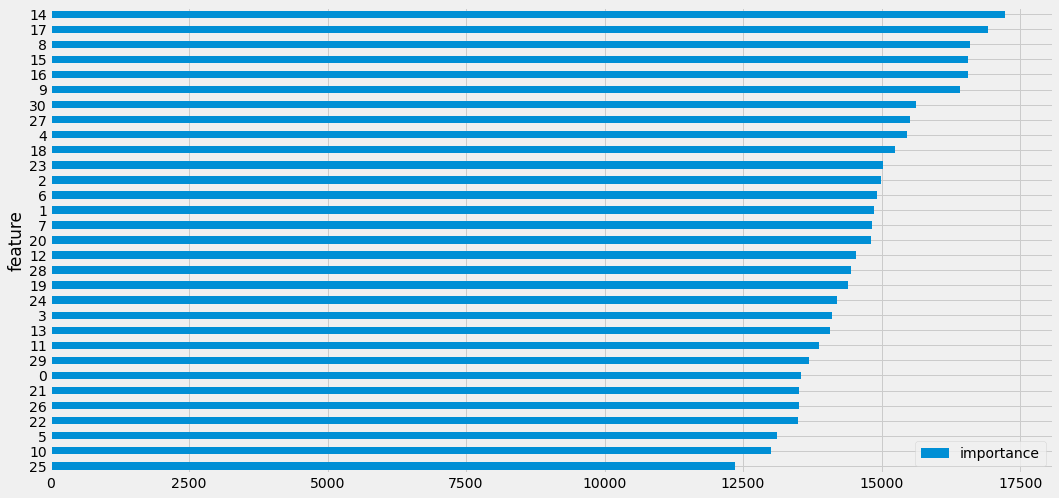

In [12]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')


## 제출 파일 생성

In [13]:
#sub = pd.read_csv(sample_file)
#sub['class']
sub = pd.read_csv(sample_file)
sub['class'] = p_tst
sub.to_csv('C:\\Users\\USER\\Desktop\\Dataset\\sub\\lgbm-sub.csv',index=False,header=False)

'''
최저 파라미터
print(params)
{'objective': 'multiclass', 'subsample_freq': 1,
 'random_state': 107, 'n_jobs': -1,
 'colsample_bytree': 0.6000000000000001, 
 'learning_rate': 0.03878586662687423, 'n_estimators': 200, 
 'num_iterations': 100, 'num_leaves': 254, 
 'subsample': 0.7000000000000001}
#90.3037%(최적) &90.5374%(좀 삭제시)& 90.5374%(주석)_0.910480349344978 
{'objective': 'multiclass', 'subsample_freq': 1, 
 'random_state': 107, 'n_jobs': -1, 'boosting_type': 'dart', 
 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.034651056924106347,
 'n_estimators': 100, 'num_iterations': 500, 'num_leaves': 31, 
 'subsample': 0.8}
91.2383%!!!!(주석 X)
{'objective': 'multiclass', 'subsample_freq': 1,
 'random_state': 107, 'n_jobs': -1, 'boosting_type': 'gbdt',
 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.035249105850575155, 
 'n_estimators': 600, 'num_iterations': 500, 'num_leaves': 127,
 'subsample': 0.6000000000000001}
90.5374%!(주석 X)
'''